## TestCase: Check for the parameter numbers for each 1D-CNN blocks and proceed with deciding their total number

In [56]:
# Importing important packages
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from keras import layers

- The block above contains three hyperparameter tuning layers for more control over future instances.
- Apart from that, numbers of blocks needed to be implemented is still a long shot.

- Considering the total number of trainable parameters, we need to do some modifications and research to find if the number makes sense.
-  Designing Bi-LSTM layer is not much of a concern since most of the idea of their efficiency is negligible and its worth relying on the trail and error ideology to test which architecture is actually reliable.
- Consider using dropouts:
    - before output fully connected layer.
    - after 1D CNN layer and before the flatten layer in 1D CNN block (if implemented) 
    - after flatten layer in the classification overhead
- Consider using Batch Normalisation layers:
    - After the 1D convolution layer.
- Note: **Avoid using batch normalisation in RNN blocks!**

In [57]:
# create 2 1D CNN blocks -> see learnable parameters

# Input layers
InputLayer = layers.Input(shape=(1000,12))

# 1D-CNN Block 1
conv1d_1 = layers.Conv1D(filters = 32, 
                                kernel_size = 5, # Usual default
                                strides = 1, # Usual default
                                activation = "relu",
                                padding = "same")(InputLayer)
BN_1 = layers.BatchNormalization()(conv1d_1)
MP1d_1 = layers.MaxPool1D(pool_size = 2)(BN_1) # referenced usual default for ptbxl
DropOut_1 = layers.Dropout(0.3)(MP1d_1) # referenced usual default for ptbxl

# 1D-CNN Block 2
conv1d_2 = layers.Conv1D(filters = 64, 
                                kernel_size = 5, # Usual default
                                strides = 1, # Usual default
                                activation = "relu",
                                padding = "same")(DropOut_1)
BN_2 = layers.BatchNormalization()(conv1d_2)
MP1d_2 = layers.MaxPool1D(pool_size = 2)(BN_2) # referenced usual default for ptbxl
DropOut_2 = layers.Dropout(0.3)(MP1d_2)

# 1D-CNN Block 3
conv1d_3 = layers.Conv1D(filters = 128, 
                                kernel_size = 5, # Usual default
                                strides = 1, # Usual default
                                activation = "relu",
                                padding = "same")(DropOut_2)
BN_3 = layers.BatchNormalization()(conv1d_3)
MP1d_3 = layers.MaxPool1D(pool_size = 2)(BN_3) # referenced usual default for ptbxl
DropOut_3 = layers.Dropout(0.3)(MP1d_3)

# Bidirectional LSTM Block 1
Bidirectional_1 = layers.Bidirectional(
    layers.LSTM(64, return_sequences = True))(DropOut_3)

# Bidirectional LSTM Block 2
Bidirectional_2 = layers.Bidirectional(
    layers.LSTM(32))(Bidirectional_1)

# Classification Overhead
Dense_2 = layers.Dense(units = 128,
                      activation = "relu")(Bidirectional_2)
DropOut_Classification = layers.Dropout(0.3)(Dense_2)
OutputLayer = layers.Dense(units = 7,# referenced usual default for ptbxl
                              activation = "sigmoid",# referenced usual default for ptbxl
                              )(DropOut_Classification)

# Model Creation
model = tf.keras.Model(inputs = InputLayer,
                            outputs = OutputLayer,
                            name = "TestCaseModel_Conv_2_Blocks")

In [58]:
# Subclass Custom Hamming Loss metric (Not using tensorflow addons here; version clash)

class HammingLoss(tf.keras.metrics.Metric):

    def __init__(self, name = "Hamming_loss", **kwargs):
        super(HammingLoss, self).__init__(name = name, **kwargs)
        self.total_mismatches = self.add_weight(name = "Total_mismatches", initializer = 'zeros', dtype = tf.float32)
        self.total_labels = self.add_weight(name = "Total_labels", initializer = 'zeros', dtype = tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # caste predictions and targets in tf.float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

        # Calculate mismatches
        mismatches = tf.cast((tf.math.count_nonzero(tf.math.not_equal(y_true, y_pred), axis=-1)), tf.float32)

        # Find number of labels and batch size
        num_label = tf.cast(tf.shape(y_true)[-1], tf.float32) # shape is (rows, columns) and columns = number of elements in array
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32) # shape is (rows, columns) and rows = batch size per array
        
        # Update number of mismatches and total labels count
        self.total_mismatches.assign_add(tf.reduce_sum(mismatches)) # reduce sum adds all the elements in an array (here, instance)
        self.total_labels.assign_add(batch_size * num_label) # total label count = number of labels x batch size per instance

    def result(self):
        return self.total_mismatches / self.total_labels # Hamming Loss formula
    
    def reset_state(self): # reset atttributes
        self.total_mismatches.assign(0.)
        self.total_labels.assign(0.)

In [59]:
# Subclass Custom Hamming score metric

class HammingScore(tf.keras.metrics.Metric):

    def __init__(self, name = "Hamming_score", **kwargs):
        super(HammingScore, self).__init__(name = name, **kwargs)
        self.total_mismatches = self.add_weight(name = "Total_mismatches", initializer = 'zeros', dtype = tf.float32)
        self.total_labels = self.add_weight(name = "Total_labels", initializer = 'zeros', dtype = tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # caste predictions and targets in tf.float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

        # Calculate mismatches
        mismatches = tf.cast((tf.math.count_nonzero(tf.math.not_equal(y_true, y_pred), axis=-1)), tf.float32)

        # Find number of labels and batch size
        num_label = tf.cast(tf.shape(y_true)[-1], tf.float32) # shape is (rows, columns) and columns = number of elements in array
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32) # shape is (rows, columns) and rows = batch size per array
        
        # Update number of mismatches and total labels count
        self.total_mismatches.assign_add(tf.reduce_sum(mismatches)) # reduce sum adds all the elements in an array (here, instance)
        self.total_labels.assign_add(batch_size * num_label) # total label count = number of labels x batch size per instance

    def result(self):
        return 1 - (self.total_mismatches / self.total_labels) # Hamming Score = 1 - Hamming loss
    
    def reset_state(self): # reset atttributes
        self.total_mismatches.assign(0.)
        self.total_labels.assign(0.)

In [60]:

# Model Compilation (loss function and optimiser) 
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.binary_focal_crossentropy,
              metrics = [tf.keras.metrics.AUC(curve = "ROC", name = "ROC-AUC"),
                         tf.keras.metrics.Recall,
                         tf.keras.metrics.Precision,
                         tf.keras.metrics.FBetaScore(beta = 2.0, average = "weighted"),
                         tf.keras.metrics.BinaryAccuracy,
                         HammingLoss(),
                         HammingScore()])

In [61]:
model.summary()

Model: "TestCaseModel_Conv_2_Blocks"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1000, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 1000, 32)       │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 500, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 250, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 250, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 125, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,495 (794.90 KB)

 Trainable params: 203,047 (793.15 KB)

 Non-trainable params: 448 (1.75 KB)

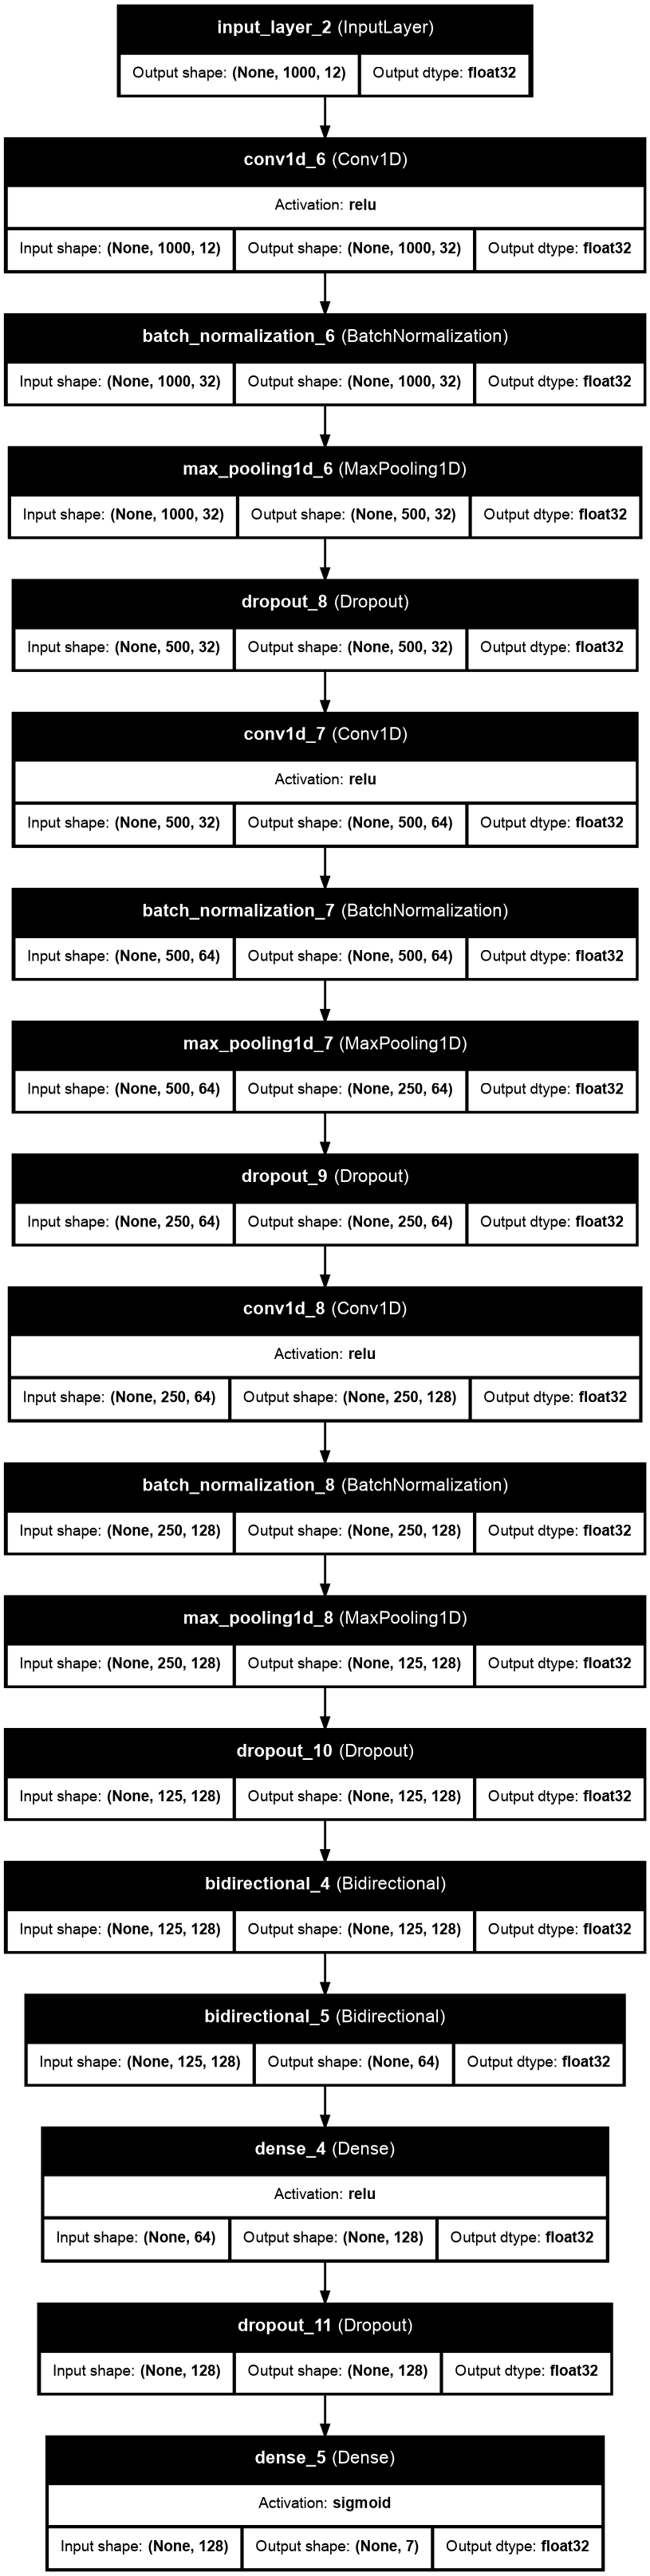

In [62]:
# Visualise The Model

tf.keras.utils.plot_model(model,
                          dpi = 100,
                          to_file = 'Final.png',
                          show_shapes = True,
                          show_dtype = True,
                          show_layer_names = True,
                          show_layer_activations = True)

## De-pickling training data

In [63]:
# load train dependant vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/X_TRAIN.pkl", "rb") as f:
    x_train = pickle.load(f)

In [64]:
# load train target vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/Y_TRAIN.pkl", "rb") as f:
    y_train = pickle.load(f)

In [65]:
# Check the data
print(f"The shape of dependent variables is {x_train.shape}.")
print(f"The shape of independent variables is {y_train.shape}.")

The shape of dependent variables is (12123, 1000, 12).
The shape of independent variables is (12123,).


In [66]:
# load test dependant vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/X_TEST.pkl", "rb") as f:
    x_test = pickle.load(f)

In [67]:
# load test target vars
with open("/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/Y_TEST.pkl", "rb") as f:
    y_test = pickle.load(f)

In [68]:
# Check the data
print(f"The shape of dependent variables is {x_test.shape}.")
print(f"The shape of independent variables is {y_test.shape}.")

The shape of dependent variables is (1512, 1000, 12).
The shape of independent variables is (1512,).


The data seems to be correctly loaded!

## Trial Training Session

In [69]:
# x trial batch prep
trial_x_train = tf.cast(x_train, dtype=tf.float32) # for converting the numpy arrays into tensors of float32
print(f"the length for the both must be {len(trial_x_train)}")

# testing data preprocessing
trial_x_test = tf.cast(x_test, dtype = tf.float32)
print(f"The datatype for the testing signal data is {type(trial_x_test)}")
print(f"\nLet us see the first entry:\n {trial_x_test[1]}")
print(f"\nTotal number of signals obtained from patients: {len(trial_x_test)}")

the length for the both must be 12123
The datatype for the testing signal data is <class 'tensorflow.python.framework.ops.EagerTensor'>

Let us see the first entry:
 [[ 0.00809643  0.02118633  0.01307777 ... -0.00297517 -0.00599571
  -0.00397102]
 [ 0.02310487  0.02193361 -0.00116536 ... -0.00250275 -0.00507634
  -0.00340584]
 [ 0.02422108  0.02496292  0.0006977  ... -0.00265434 -0.00244668
  -0.00100723]
 ...
 [ 0.26132208  0.26762414  0.00544839 ...  0.03903596  0.08776658
   0.02479506]
 [ 0.23355836  0.23503971  0.00150268 ...  0.03900548 -0.02465511
   0.0219655 ]
 [ 0.02392498  0.01611293 -0.00769422 ...  0.02712256  0.02170888
   0.01636948]]

Total number of signals obtained from patients: 1512


**Considerations for target variables**

- Convert these pandas series into list.
- Setting up string lookup layer
- Setting up adapt layer (to create adapted vocabulary)
- Convert it

In [70]:
# analyse dtype of y_train
print(f"The data type of train target variables is {type(y_train)}")
print(f"The data type of test target variables is {type(y_test)}")

The data type of train target variables is <class 'pandas.core.series.Series'>
The data type of test target variables is <class 'pandas.core.series.Series'>


In [71]:
# convert into list
y_train = y_train.to_list()
y_test = y_test.to_list()
print(f"The data type of train target variables is {type(y_train)}")
print(f"The data type of test target variables is {type(y_test)}")

The data type of train target variables is <class 'list'>
The data type of test target variables is <class 'list'>


In [72]:
# Analyse
print(y_train[1:10])
print(y_test[1:10])

[['NORM'], ['NORM'], ['NORM'], ['NORM'], ['NORM'], ['NORM'], ['STTC'], ['NORM'], ['NORM']]
[['NORM'], ['CD'], ['NORM'], ['NORM'], ['NORM'], ['NORM'], ['NORM'], ['CD'], ['STTC']]


In [73]:
# y trail batch split
trial_y_train = y_train
print(f"the length for the both must be {len(trial_y_train)}")
trial_y_test = y_test
print(f"the length for the both must be {len(trial_y_test)}")

the length for the both must be 12123
the length for the both must be 1512


In [74]:
# convert the list into a ragged tensor (handles non-rectangular data)
ragged_target_variable_train = tf.ragged.constant(trial_y_train)
ragged_target_variable_test = tf.ragged.constant(trial_y_test)

In [75]:
# String Lookup layer
Str_Lookup_layer = layers.StringLookup(output_mode="multi_hot")
Str_Lookup_layer.adapt(ragged_target_variable_train)
Str_Lookup_layer.adapt(ragged_target_variable_test)
Str_Lookup_layer.get_vocabulary() # see the vocab

['[UNK]',
 np.str_('NORM'),
 np.str_('STTC'),
 np.str_('MI'),
 np.str_('CD'),
 np.str_('HYP'),
 np.str_('HYP_HR')]

In [76]:
# Get the final converted form
trial_y_train = Str_Lookup_layer(ragged_target_variable_train)
trial_y_test = Str_Lookup_layer(ragged_target_variable_test)

In [77]:
len(trial_y_train)
len(trial_y_test)

1512

In [78]:
# test the first entry
print(trial_y_train[7]) # STTC entry
print(trial_y_test[7]) # NORM entry

tf.Tensor([0 0 1 0 0 0 0], shape=(7,), dtype=int64)
tf.Tensor([0 1 0 0 0 0 0], shape=(7,), dtype=int64)


**Notes**

For Epochs:

- small dataset (<10k>) : epochs = 10-50
- medium dataset (10k-100k) : epochs = 20-200
- large datsets (100k+) : epochs = 50-500+
- fine-tuning/pre-trained models : epochs = 3-10

For batch size: (& ^gradient estimate stability & ^convergence & !Generaliastion)

- standard/baseline = 32
- Image Classification  = 32/64/128
- NLP = ~16-32
- Limited Memory/Small dataset = 8/16

In [79]:
# Data is imbalanced - go for weighted training
# Define function to compute class weight

def ComputeClassWeights(y_train):
    num_samples = len(y_train)
    num_classes = y_train.shape[1]

    class_weight = {}
    for i in range(num_classes):
        pos = np.sum(y_train[:, i])
        neg = num_samples - pos

        if pos > 0:
            weight = neg / pos
            class_weight[i] = min(weight, 10.0)
        else:
            class_weight[i] = 1.0

    
    print(f"Class weigths: ")
    for i, weight in class_weight.items():
        pos_ratio = np.sum(y_train[:,i])/len(y_train) * 100
        print(f"class {i} : {weight:.2f} (prevalence : {pos_ratio:.1f}%)")

    return class_weight        

In [80]:
# Apply class weights

current_class_weights = ComputeClassWeights(trial_y_train)

Class weigths: 
class 0 : 1.00 (prevalence : 0.0%)
class 1 : 1.11 (prevalence : 47.4%)
class 2 : 3.30 (prevalence : 23.2%)
class 3 : 3.27 (prevalence : 23.4%)
class 4 : 3.51 (prevalence : 22.2%)
class 5 : 10.00 (prevalence : 8.1%)
class 6 : 10.00 (prevalence : 4.3%)


In [81]:
# train the model

History = model.fit(
    x = trial_x_train,
    y = trial_y_train,
    epochs = 10,
    batch_size = 32
)

Epoch 1/10


379/379 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - Hamming_loss: 0.1892 - Hamming_score: 0.8108 - ROC-AUC: 0.7529 - binary_accuracy: 0.8108 - fbeta_score: 0.3016 - loss: 0.1065 - precision_2: 0.4511 - recall_2: 0.1400
Epoch 2/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - Hamming_loss: 0.1857 - Hamming_score: 0.8143 - ROC-AUC: 0.7633 - binary_accuracy: 0.8143 - fbeta_score: 0.3024 - loss: 0.1037 - precision_2: 0.4757 - recall_2: 0.1120
Epoch 3/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - Hamming_loss: 0.1857 - Hamming_score: 0.8143 - ROC-AUC: 0.7656 - binary_accuracy: 0.8143 - fbeta_score: 0.3016 - loss: 0.1031 - precision_2: 0.4713 - recall_2: 0.0945
Epoch 4/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - Hamming_loss: 0.1840 - Hamming_score: 0.8160 - ROC-AUC: 0.7661 - binary_accuracy: 0.8160 - fbeta_score: 0.3017 - loss: 0.1029 - precision_2: 0.4944 - recall_2: 0.0857
Epoch 5/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - Hamming_loss: 0.1847 - Hamming_score: 0.8153 - ROC-AUC: 0.7642 

In [82]:
# evaluate the model
Evaluation_result = model.evaluate(
    x = trial_x_test,
    y = trial_y_test,
    batch_size = 32   
)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - Hamming_loss: 0.1841 - Hamming_score: 0.8159 - ROC-AUC: 0.7656 - binary_accuracy: 0.8159 - fbeta_score: 0.2950 - loss: 0.1027 - precision_2: 0.3333 - recall_2: 0.0021


In [83]:
results = model.predict(x = trial_x_test[99:100])
print(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
[[0.03514229 0.4866326  0.39674568 0.41042468 0.39276555 0.29781994
  0.24916302]]


> Results: **The test run was successful. Now we will adapt this pipeline to our cloud instance.**